In [95]:
from matplotlib import pyplot as plt
import pickle
from IPython.display import display, HTML
import pandas as pd

In [97]:
time_surprise = '../Data/time_surprise.txt'
time_ann = '../Data/time_list.txt'
accuracy_file = '../Data/accuracy.txt'

In [98]:
with open (time_surprise, 'rb') as p:
    sur_time = pickle.load(p)

In [99]:
with open (time_ann, 'rb') as p:
    ann_time = pickle.load(p)

In [116]:
with open ('../Data/knn_rmse.txt', 'rb') as p:
    rmse_values = pickle.load(p)

In [100]:
ann_time_data = pd.DataFrame(ann_time, columns=['No_of_Hash_Fns', 'No_of_Bands', 'Time'])
ann_time_data['Surprise_Time'] = sur_time[0]
ann_time_data['Change'] = (ann_time_data['Surprise_Time'] - ann_time_data['Time'])/ann_time_data['Time']

In [101]:
time_groupby = ann_time_data.groupby('No_of_Hash_Fns')['Time'].mean().reset_index()

We will first plot the average time taken to calculate the similarity matrix. The X Axis shows the number of Hash Functions 

The baseline would be the time taken to calculate the similarity matrix using the Surprise Package

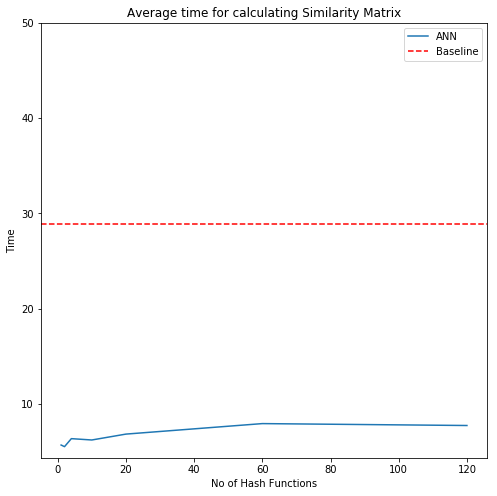

In [102]:
plt.figure(figsize=(8,8))
plt.plot(time_groupby['No_of_Hash_Fns'], time_groupby['Time'] , label = 'ANN')
plt.axhline(y=sur_time[0], color='r', linestyle='--', label = 'Baseline')
plt.ylim(top = 50)
plt.legend()
plt.ylabel('Time')
plt.xlabel('No of Hash Functions')
plt.title('Average time for calculating Similarity Matrix')
plt.savefig('../Figures/ANN_Plots/avg_time.png')

We can see from the plot above, the time taken to calculate the similarity matrix is almost three times as fast for our dataset. As the size of the dataset increaes, we see that we can approximate the similarity matrix through ANN. This allows us to scale efficiently

We will now see the tuning of the parameters. Seeing the Cross Validation Grid

In [103]:
with open (accuracy_file, 'rb') as p:
    accuracy = pickle.load(p)

In [104]:
accuracy_data = pd.DataFrame(accuracy, columns=['No_of_Hash_Fns', 'No_of_Bands', 'Sim_Threshold', 
                                                'Pred_Threshold', 'RMSE', 'Precision'])

In [105]:
accuracy_data.head(2)

,No_of_Hash_Fns,No_of_Bands,Sim_Threshold,Pred_Threshold,RMSE,Precision
0,1,1,0.05,3.0,1.019555,0.882197
1,1,1,0.05,3.5,1.019555,0.702326


Lets first see which prediction threshold gives us the best precision. 

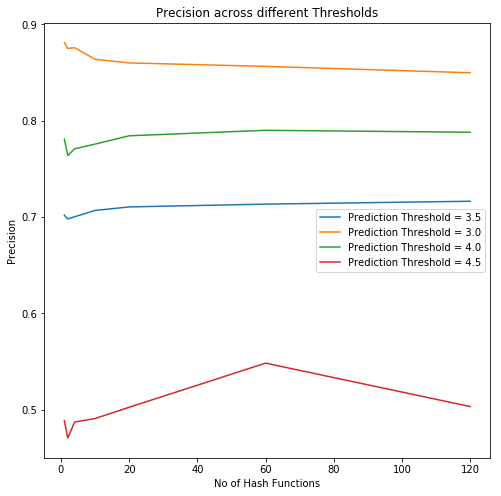

In [106]:
threshold_data_rmse = accuracy_data.groupby(['No_of_Hash_Fns', 'Pred_Threshold'])['Precision'].mean().reset_index()
plt.figure(figsize=(8,8))
for val in list(set(threshold_data_rmse['Pred_Threshold'])):
    temp = threshold_data_rmse[threshold_data_rmse.Pred_Threshold == val]
    plt.plot(temp['No_of_Hash_Fns'], temp['Precision'], label='Prediction Threshold = ' + str(val))
plt.xlabel('No of Hash Functions')
plt.ylabel('Precision')
plt.title("Precision across different Thresholds")
plt.legend()
plt.savefig('../Figures/ANN_Plots/pred_threshold_precision.png')

We can see that the Prediction threshold of 3 gives us the best values but we should be very careful regarding that. Depending on the business case, we would be more happy to keep a threshold rating of 4 as that would give us a good precision value and we would be happy showing the results to the customer

Now lets see which threshold gives us the best value for the RMSE and the Precisions 

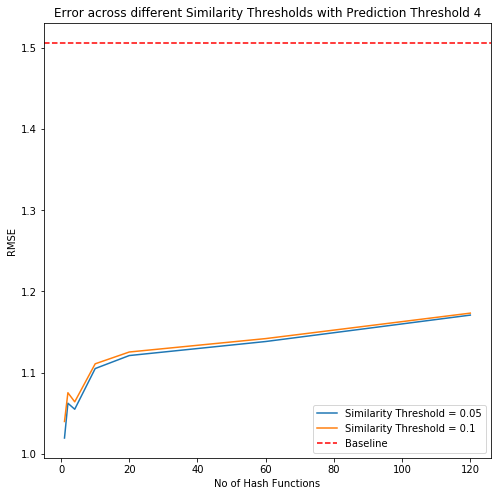

In [118]:
threshold_data_rmse = accuracy_data[accuracy_data.Pred_Threshold == 4].groupby(['No_of_Hash_Fns', 'Sim_Threshold'])['RMSE'].mean().reset_index()
plt.figure(figsize=(8,8))
for val in list(set(threshold_data_rmse['Sim_Threshold'])):
    temp = threshold_data_rmse[threshold_data_rmse.Sim_Threshold == val]
    plt.plot(temp['No_of_Hash_Fns'], temp['RMSE'], label='Similarity Threshold = ' + str(val))
plt.xlabel('No of Hash Functions')
plt.ylabel('RMSE')
plt.title("Error across different Similarity Thresholds with Prediction Threshold 4")
plt.axhline(y=rmse_values[1], color='r', linestyle='--', label = 'Baseline')
plt.legend()
plt.savefig('../Figures/ANN_Plots/sim_threshold_rmse.png')

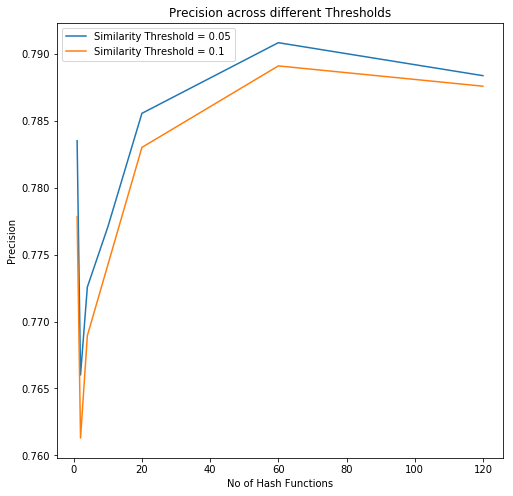

In [108]:
threshold_data_precision = accuracy_data[accuracy_data.Pred_Threshold == 4].groupby(['No_of_Hash_Fns', 'Sim_Threshold'])['Precision'].mean().reset_index()
plt.figure(figsize=(8,8))
for val in list(set(threshold_data_precision['Sim_Threshold'])):
    temp = threshold_data_precision[threshold_data_precision.Sim_Threshold == val]
    plt.plot(temp['No_of_Hash_Fns'], temp['Precision'], label='Similarity Threshold = ' + str(val))
plt.xlabel('No of Hash Functions')
plt.ylabel('Precision')
plt.title("Precision across different Thresholds")
plt.legend()
plt.savefig('../Figures/ANN_Plots/sim_threshold_precision.png')

We should be a bit careful regarding the average for the RMSE. The extreme values for small number of bands are increasing the values. Keeping a similarity threshold of 0.05 gives us more precisison though which is extremely important for us

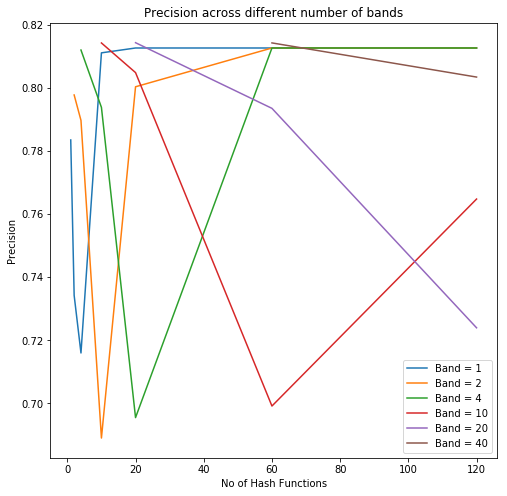

In [109]:
threshold_data_precision = accuracy_data[(accuracy_data.Pred_Threshold == 4) & (accuracy_data.Sim_Threshold == 0.05)]
plt.figure(figsize=(8,8))
for val in sorted(list(set(threshold_data_precision['No_of_Bands']))):
    temp =threshold_data_precision[threshold_data_precision.No_of_Bands == val]
    plt.plot(temp['No_of_Hash_Fns'], temp['Precision'], label='Band = ' + str(val))
plt.xlabel('No of Hash Functions')
plt.ylabel('Precision')
plt.title("Precision across different number of bands")
plt.legend()
plt.savefig('../Figures/ANN_Plots/bands_precision.png')

We see that the values for Band 1 and Band 2 are not present after

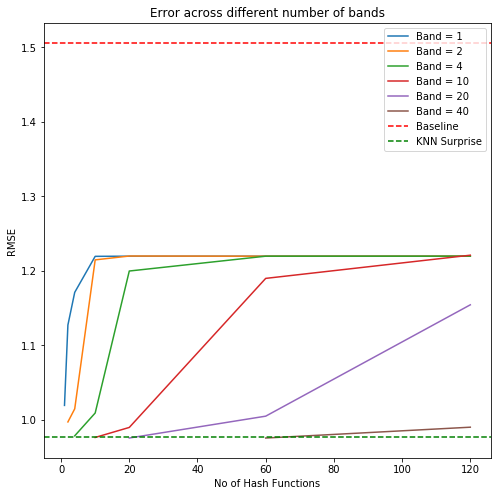

In [119]:
threshold_data_precision = accuracy_data[(accuracy_data.Pred_Threshold == 4) & (accuracy_data.Sim_Threshold == 0.05)]
plt.figure(figsize=(8,8))
for val in sorted(list(set(threshold_data_precision['No_of_Bands']))):
    temp =threshold_data_precision[threshold_data_precision.No_of_Bands == val]
    plt.plot(temp['No_of_Hash_Fns'], temp['RMSE'], label='Band = ' + str(val))
plt.xlabel('No of Hash Functions')
plt.ylabel('RMSE')
plt.title("Error across different number of bands")
plt.axhline(y=rmse_values[1], color='r', linestyle='--', label = 'Baseline')
plt.axhline(y=rmse_values[0], color='g', linestyle='--', label = 'KNN Surprise')
plt.legend()
plt.savefig('../Figures/ANN_Plots/bands_rmse.png')

We see from the above 2 graphs that we can choose to have 60 Hash Functions with a Band Size of 20 or 120 hash Functions with a band size of 40. The others either are overfitting or do not have a good precision

Going for simplicity, our final ANN will comprise of 120 Hash Functions with the number of Bands being equal to 40

RMSE Value: 0.990 
Precision: 0.803

When looking at the plots, we see that our approximate nearest neighbour algorithm does not outperform the KNN Algorithm in terms of Root Mean Square Error. But our algorithm takes 3 times as less time to excute

Sacrificing a bit of accuracy, we are able to compute the similarity matrix quickly and at scale

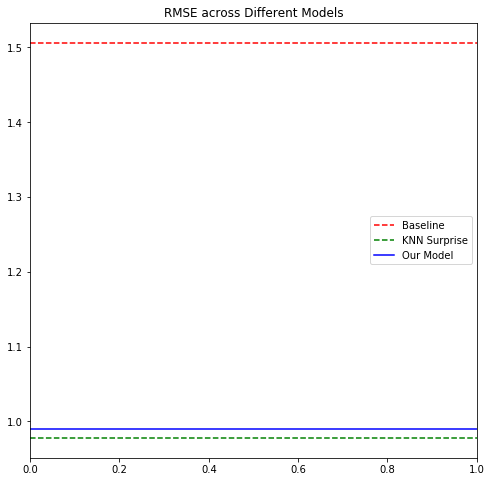

In [123]:
plt.figure(figsize=(8,8))
plt.axhline(y=rmse_values[1], color='r', linestyle='--', label = 'Baseline')
plt.axhline(y=rmse_values[0], color='g', linestyle='--', label = 'KNN Surprise')
plt.axhline(y=0.990, color='b', linestyle='-', label = 'Our Model')
plt.legend()
plt.title("RMSE across Different Models")
plt.savefig('../Figures/ANN_Plots/final_rmse.png')